<a href="https://colab.research.google.com/github/Suryansh109/project_covid_v1/blob/master/DDos_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#setting up the spark and hadoop setup
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark
#installing kaggle library to fetch the dataset  directly from kaggle and load it colab cluster
!pip install -q kaggle

In [3]:
import os

os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]="/content/spark-3.0.1-bin-hadoop3.2"


In [4]:
#finding spark and setting up the spark session.
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [8]:
from google.colab import files
files.upload()

{}

In [9]:
#to make kaggle.json directory 
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"suryansh1001","key":"9814931985ed3e83f62d48c7bb58f7b2"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# this command helps to download the  dataset directly from the kaggle database
!kaggle datasets download -d devendra416/ddos-datasets

100% 2.67G/2.68G [02:12<00:00, 33.6MB/s]
100% 2.68G/2.68G [02:12<00:00, 21.8MB/s]


In [11]:
#!mkdir ddos_raw_data
!unzip ddos-datasets.zip -d ddos_raw_data

Archive:  ddos-datasets.zip
  inflating: ddos_raw_data/ddos_balanced/final_dataset.csv  
  inflating: ddos_raw_data/ddos_imbalanced/unbalaced_20_80_dataset.csv  


In [12]:
!ls -ltr  ddos_raw_data/*/*

-rw-r--r-- 1 root root 6794744782 Oct 22  2019 ddos_raw_data/ddos_balanced/final_dataset.csv
-rw-r--r-- 1 root root 4121715182 Oct 22  2019 ddos_raw_data/ddos_imbalanced/unbalaced_20_80_dataset.csv


In [13]:
balanced_data=spark.read.option("header",True).option("inferSchema",True).format("csv").load("ddos_raw_data/ddos_balanced/final_dataset.csv")

In [14]:
from pyspark.sql import functions

In [15]:
#to perform  any arithmetical operation the datatypes of schema should be understood, hence checking out the schema.
balanced_data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Flow ID: string (nullable = true)
 |-- Src IP: string (nullable = true)
 |-- Src Port: integer (nullable = true)
 |-- Dst IP: string (nullable = true)
 |-- Dst Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Tot Fwd Pkts: integer (nullable = true)
 |-- Tot Bwd Pkts: integer (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nul

In [ ]:
balanced_data.count()

12794627

In [16]:
balanced_data.show()

+---+--------------------+-------------+--------+------------+--------+--------+--------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+------------------+------------------+---------------+---------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------+-----------+-----------------+------------------+-----------+-----------+-----------+-----------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+------------------+------------------+-----------+-----------+-----------------+------------------+-----------------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------------+------------------+------------------+--------------+--------------+----------------+------------

In [17]:
#checking different attacks with highest on the Top 
attack_group=balanced_data.groupBy("label").count().orderBy("count",ascending=False)

In [ ]:
attack_group.cache()

DataFrame[label: string, count: bigint]

In [18]:
import pandas as pd

In [19]:
attack_group_pd=attack_group.toPandas()

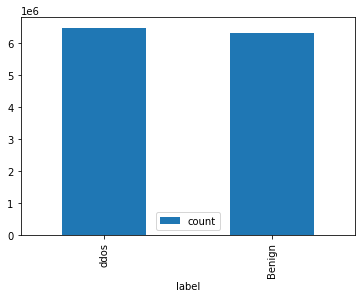

In [20]:
# from the available dataset,we can infer that both the types of attack are almost in vicinity.
import matplotlib.pyplot as plt
attack_group_pd.plot(kind='bar',x='label',y='count')
plt.show()

In [ ]:
attack_group_pd

,label,count
0,ddos,6472647
1,Benign,6321980


In [45]:
#checking flowid through which the types of attacks has been done most
balanced_data.groupBy("label").agg({"Flow Duration":"sum"}).show()


+------+------------------+
| label|sum(Flow Duration)|
+------+------------------+
|  ddos|2.0193915332131E13|
|Benign|8.4972712104317E13|
+------+------------------+



In [71]:
from pyspark.sql.types import *
from matplotlib import pyplot
hourly_flow=balanced_data.select(functions.from_unixtime(functions.unix_timestamp('Timestamp', 'MM/dd/yyyy hh:mm:ss a')).cast(TimestampType()).alias("timestamp"),"Flow Duration").groupBy(functions.hour("timestamp"))\
.agg({"Flow Duration":"sum"}).orderBy("hour(timestamp)",ascending=True).toPandas()

Query: The Idea is to check the flow duration in hourly basis. concverting he datatype of the timestamp column fromm string to timestamp and also converting the format to 24 hours.

In [111]:
#pyplot.scatter(hourly_flow["hour(timestamp)"],hourly_flow["sum(Flow Duration)"])

hourly_flow.rename(columns={'hour(timestamp)':'hours','sum(Flow Duration)':'total_flow_duration_per_hour'},inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [109]:
hourly_flow=hourly_flow.dropna()

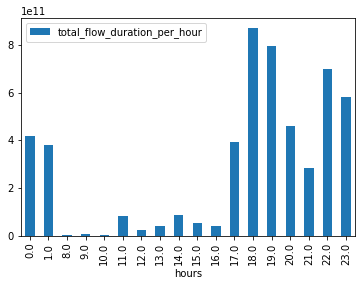

In [112]:
#need to check which labels are accuring during peak hours( Ddos or Benign?)

import matplotlib.pyplot as plt
hourly_flow.plot(kind='bar',x='hours',y='total_flow_duration_per_hour')
plt.show()

From above graph, we can observe the total_flow_duration on hourly basis is peak in Evening time and there is no flow between 01 am to 07 am.

In [51]:
#Establishing relationshing in data
#converting spark dataframe into pandas dataframe
from pyspark.sql.types import *
sample_data=balanced_data.limit(2000)
sample_data=sample_data.withColumn("Timestamp",functions.from_unixtime(functions.unix_timestamp('Timestamp', 'MM/dd/yyyy hh:mm:ss a')).cast(TimestampType()).alias("timestamp"))
pd_balanced=sample_data.toPandas()

In [34]:
pd_balanced

,_c0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,...,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,624,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,2010-12-06 08:34:32,3974862,29,44,86.0,59811.0,86.0,0.0,2.965517,15.969799,1460.0,0.0,1359.340909,372.027190,15068.950821,18.365417,55206.416667,195478.316654,1566821.0,167.0,3735347.0,133405.25,341775.688712,1805015.0,167.0,3974862.0,92438.651163,248174.820574,1566821.0,3997.0,0,0,0,...,0.0,1460.0,809.418919,728.862428,531240.438541,0,1,0,0,0,0,0,0,1.0,820.506849,2.965517,1359.340909,0,0,0,0,0,0,29,86,44,59811,-1,5840,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,625,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,2010-12-06 08:34:36,63,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,31746.031746,63.000000,0.000000,63.0,63.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,1.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,0,1,0,-1,17520,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,626,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,2010-12-06 08:34:36,476078,2,6,86.0,3037.0,86.0,0.0,43.000000,60.811183,1460.0,0.0,506.166667,740.224403,6559.849436,16.803969,68011.142857,110862.707451,232203.0,6.0,134.0,134.00,0.000000,134.0,134.0,476078.0,95215.600000,123467.303580,232601.0,6.0,0,0,0,...,0.0,1460.0,347.000000,632.515217,400075.500000,0,1,0,0,0,0,0,0,3.0,390.375000,43.000000,506.166667,0,0,0,0,0,0,2,86,6,3037,-1,5840,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,627,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,2010-12-06 08:34:37,151,2,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,19867.549669,75.500000,98.287843,145.0,6.0,145.0,145.00,0.000000,145.0,145.0,0.0,0.000000,0.000000,0.0,0.0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,1,0,-1,17520,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,628,192.168.4.118-203.73.24.75-4506-80-6,192.168.4.118,4506,203.73.24.75,80,6,2010-12-06 08:34:37,472507,2,5,73.0,1050.0,73.0,0.0,36.500000,51.618795,1050.0,0.0,210.000000,469.574275,2376.684367,14.814595,78751.166667,118675.492251,232355.0,7.0,179.0,179.00,0.000000,179.0,179.0,472507.0,118126.750000,131726.857333,232875.0,7.0,0,0,0,...,0.0,1050.0,140.375000,368.430624,135741.125000,0,1,0,0,0,0,0,0,2.0,160.428571,36.500000,210.000000,0,0,0,0,0,0,2,73,5,1050,-1,5840,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5215,192.168.2.110-67.220.214.50-4935-80-6,192.168.2.110,4935,67.220.214.50,80,6,2010-12-06 09:16:23,579429,10,20,62.0,24500.0,62.0,0.0,6.200000,19.606121,1

In [52]:
#checking for the correlation between columms
pd_balanced=pd_balanced.drop(columns=['_c0'])
pd_corr=pd_balanced.corr()
pd_corr

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Src Port,1.000000,0.481278,NaN,0.049815,0.047245,0.060872,0.063584,0.056032,0.215374,-0.030616,0.027878,0.061769,0.059087,-0.003861,0.059783,0.026282,-0.004350,0.020324,-0.189515,0.054937,0.059631,-0.189882,0.234704,0.000802,0.067583,0.253494,0.243179,-0.072419,-0.053891,-0.055670,-0.058107,-0.038546,NaN,-0.003861,NaN,NaN,0.045802,0.061892,0.020297,0.020350,NaN,0.058648,0.063735,0.054722,0.040411,-0.212852,0.062291,NaN,-0.003861,-0.062291,NaN,NaN,NaN,0.047296,0.062980,0.027878,0.059783,NaN,NaN,NaN,NaN,NaN,NaN,0.047245,0.063584,0.060872,0.056032,NaN,0.085677,-0.036853,NaN,-0.068476,-0.036304,-0.070737,-0.061094,-0.020330,-0.008595,-0.020847,-0.019492
Dst Port,0.481278,1.000000,NaN,0.188697,0.193908,0.198253,0.293490,0.190700,0.381437,-0.001120,0.061979,0.116392,0.080633,-0.001120,0.106247,0.048254,0.001770,-0.021232,-0.005828,0.052892,0.185013,-0.006409,0.249216,0.006184,0.057162,0.248724,0.269708,0.034059,0.003882,0.003189,0.012324,-0.004142,NaN,-0.001120,NaN,NaN,0.203470,0.198536,-0.021269,-0.021193,NaN,0.080649,0.105951,0.088332,0.091484,-0.007509,0.050263,NaN,-0.001120,-0.050263,NaN,NaN,NaN,-0.038153,0.103739,0.061979,0.106247,NaN,NaN,NaN,NaN,NaN,NaN,0.193908,0.293490,0.198253,0.190700,NaN,0.014685,0.100287,NaN,-0.002342,-0.001299,-0.002422,-0.002088,-0.002811,-0.001233,-0.002862,-0.002708
Protocol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flow Duration,0.049815,0.188697,NaN,1.000000,0.424307,0.410486,0.454995,0.405899,0.172238,-0.003668,-0.051150,0.000169,0.054683,0.135527,0.154963,-0.037609,-0.059485,-0.086257,0.667878,0.540116,0.994471,0.619987,0.768997,0.423847,0.543714,0.760673,0.143252,0.339252,0.198116,0.254749,0.294692,0.138559,NaN,0.135527,NaN,NaN,0.426449,0.409834,-0.086405,-0.086105,NaN,0.058697,0.151012,0.083263,0.109113,0.096218,0.034329,NaN,0.135527,-0.034329,NaN,NaN,NaN,-0.135939,0.143359,-0.051150,0.154963,NaN,NaN,NaN,NaN,NaN,NaN,0.424307,0.454995,0.410486,0.405899,NaN,-0.005209,0.408851,NaN,0.191015,0.090570,0.193890,0.174806,0.249636,0.106646,0.253538,0.240950
Tot Fwd Pkts,0.047245,0.193908,NaN,0.424307,1.000000,0.998411,0.830018,0.997822,0.285002,-0.003227,-0.048548,0.028898,0.304085,0.023544,0.427204,0.148902,0.308585,-0.083086,-0.023578,0.102123,0.378403,-0.025133,0.549105,0.013410,0.103312,0.505777,0.142283,0.350688,0.097132,0.150251,0.223976,0.011691,NaN,0.023544,NaN,NaN,0.999211,0.997973,-0.083217,-0.082953,NaN,0.304242,0.426191,0.338849,0.364539,-0.029800,0.193678,NaN,0.023544,-0.193678,NaN,NaN,NaN,-0.032560,0.416718,-0.048548,0.427204,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.830018,0.998411,0.997822,NaN,-0.122447,0.837655,NaN,0.273981,0.059738,0.262426,0.269738,0.144914,0.0884

In [42]:
def color_negative_red(value):
  """
  Colors elements in a dateframe
  green if positive and red if
  negative. Does not color NaN
  values.
  """

  if value < 0:
    color = 'red'
  elif value > 0:
    color = 'green'
  elif value >
  else:
    color = 'black'

  return 'color: %s' % color

In [45]:
pd_corr.style.applymap(color_negative_red)
#columms with NAN value do not 

Red are for the columns showing negative relations.
Green are the columns showing postive relations

In [53]:
#removing Columms having NAN values and re-correlating
pd_balanced=pd_balanced.drop(columns=['Fwd Seg Size Min','Bwd Byts/b Avg','Init Fwd Win Byts','Bwd Blk Rate Avg','Bwd Pkts/b Avg','Fwd Blk Rate Avg','Fwd Pkts/b Avg','Fwd Byts/b Avg','ECE Flag Cnt','CWE Flag Count','URG Flag Cnt','RST Flag Cnt','Pkt Len Min','Bwd URG Flags','Fwd URG Flags','Fwd PSH Flags','Protocol'])
pd_corr=pd_balanced.corr()
pd_corr.style.applymap(color_negative_red)

In [57]:
#with help of gradient matrix, we can identify the Columms with highest correlation
# Set colormap equal to seaborns light green color palette
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

(pd_corr.style
  .background_gradient(cmap=cm)
  .highlight_max()
  .set_table_styles(styles))

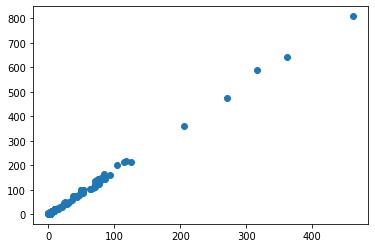

In [66]:
#from above picking two columns with high coffecient. Tot Bwd Pkts vs Tot Fwd Pkt

plt.scatter(pd_balanced['Tot Fwd Pkts'],pd_balanced['Tot Bwd Pkts'])
plt.show()



In [69]:
import numpy as np

np.corrcoef(pd_balanced['Tot Fwd Pkts'],pd_balanced['Tot Bwd Pkts'])



array([[1.        , 0.99841106],
       [0.99841106, 1.        ]])

The value of 0.99 shows very strong linear relationship

In [70]:
from scipy.stats import linregress
linregress(pd_balanced['Tot Fwd Pkts'],pd_balanced['Tot Bwd Pkts'])

LinregressResult(slope=1.7874601183166705, intercept=0.2358465853336913, rvalue=0.9984110637822913, pvalue=0.0, stderr=0.0022569652822975643)

Since the p-value of 0 , coefficient has no effect to null hypothesis.

#Advanced descriptive analysis


---


# Performing below Stats columns extarcted above.
Mean,
Median,
Mode,
Standard Deviation,
Variance,
Interquartile Range,
Skewness.







In [94]:
pd_stats=pd.DataFrame(pd_balanced.describe())

In [95]:
pd_stats

,Src Port,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Bwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2000.00000,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,4395.36550,80.907500,3.266417e+06,4.772500,8.766500,42.523500,8.823111e+03,32.964500,0.024500,11.710979,18.456099,499.038000,0.02950,250.863023,200.963544,7151.713125,35627.309403,1.421433e+06,3.144974e+05,2.959285e+06,1.307129e+06,1.736886e+06,2.439361e+05,4.512977e+05,1.528290e+06,94.856000,6.345829e+05,3.392533e+04,7.224713e+04,3.582857e+05,823.007000,0.000500,96.606000,183.29000,17841.286192,17786.023210,499.662000,162.425167,209.867382,112597.648428,0.02200,0.498000,0.000500,0.502000,1.42300,171.452563,11.710979,250.863023,4.772500,42.523500,8.766500,8.823111e+03,33145.845500,0.641500,1.670636e+04,2.451031e+03,1.897793e+04,1.430005e+04,1.790362e+05,1.543869e+04,1.904782e+05,1.677869e+05
std,1949.14088,18.131832,1.606776e+07,19.220288,34.410173,104.466363,4.815465e+04,36.369309,1.095673,14.332629,20.436312,566.975079,1.31928,432.963039,223.277310,15172.754348,83998.432390,1.027669e+07,2.939012e+06,1.548644e+07,1.021268e+07,1.243213e+07,3.170086e+06,4.677935e+06,1.179460e+07,232.478499,4.456192e+06,1.121241e+05,5.092933e+05,3.531968e+06,8565.791604,0.022361,392.636344,690.05692,41993.553753,42006.595492,566.470781,276.892985,261.892390,185512.187471,0.14672,0.500121,0.022361,0.500121,0.55518,284.494232,14.332629,432.963039,19.220288,104.466363,34.410173,4.815465e+04,28289.590801,1.577093,3.572726e+05,9.446351e+04,3.923992e+05,3.430033e+05,3.188884e+06,6.270782e+05,3.333206e+06,3.103006e+06
min,1235.00000,80.000000,6.000000e+00,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.016670,6.000000e+00,0.000000e+00,6.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,20.00000,0.000000,0.008335,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,5840.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4228.75000,80.000000,7.300000e+01,1.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,33.037958,7.300000e+01,0.000000e+00,7.300000e+01,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,

In [99]:
pd_skew=pd.DataFrame(pd_balanced.skew(),columns=['skew_value'])

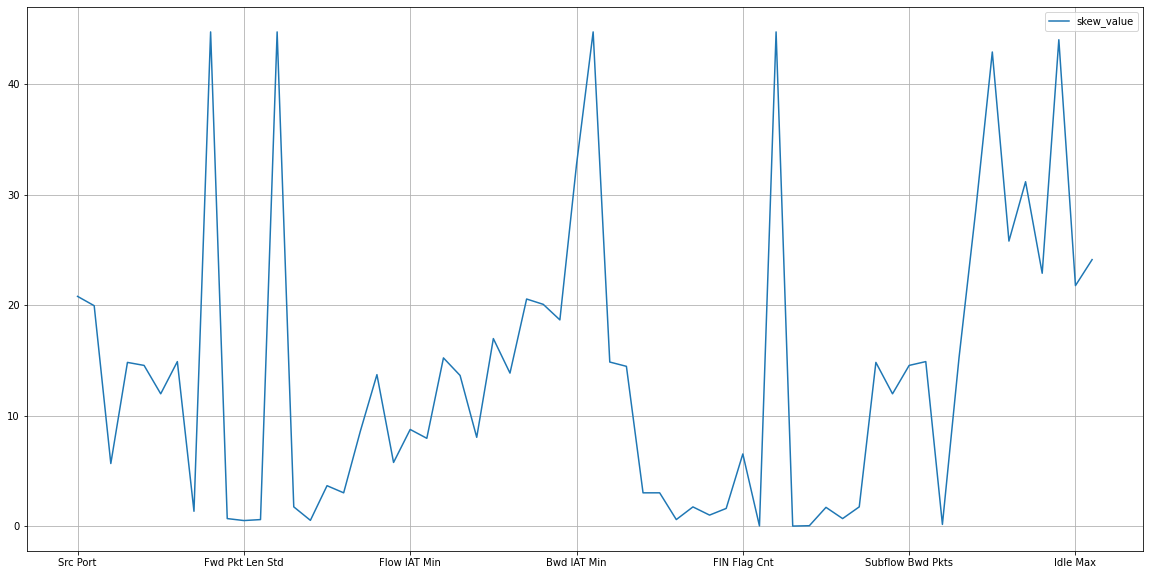

In [118]:
pd_skew.plot(figsize=(20,10),grid=True)

Featueres ranging from 0 to 0.5 are approximately symmetric.
#Conclusion:- Most of the columns(features) are having high skewed distribution.


